In [1]:
import os, itertools
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from joblib import Parallel, delayed
from IPython import embed as shell

from tools_mcginley import utils
import analyses_tools

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='ticks', font='Arial', font_scale=1, rc={
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.width': 0.25,
    'ytick.major.pad' : 2.0,
    'ytick.minor.pad' : 2.0,
    'xtick.major.pad' : 2.0,
    'xtick.minor.pad' : 2.0,
    'axes.labelpad' : 4.0,
    'axes.titlepad' : 6.0,
    } )
sns.plotting_context()

{'font.size': 12.0,
 'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'xtick.labelsize': 6.0,
 'ytick.labelsize': 6.0,
 'legend.fontsize': 6.0,
 'axes.linewidth': 0.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.25,
 'ytick.major.width': 0.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 12.0}

In [3]:
def params_melt(params, model_settings, flip_b=False):
    try:
        params = params.loc[:,params.columns!='Unnamed: 0']
    except:
        pass
    
    # flip b & z:
    if flip_b:
        params_overall = pd.DataFrame({'subj_idx': np.array(df_emp.groupby(['subj_idx']).first().index.get_level_values('subj_idx')),
                        'c': np.array(df_emp.groupby(['subj_idx']).apply(analyses_tools.behavior, 'c'))})
        b_columns = params.columns[[p[0]=='b' for p in params.columns]]
        for b_column in b_columns:
            params['{}'.format(b_column)] = params[b_column]
            for subj in params['subj_idx'].unique():
                if params_overall.loc[params_overall['subj_idx'] == subj, 'c'].values < 0:
                    params.loc[params['subj_idx'] == subj, '{}'.format(b_column)] = params.loc[params['subj_idx'] == subj, '{}'.format(b_column)] * -1
        z_columns = params.columns[[p[0]=='z' for p in params.columns]]
        for z_column in z_columns:
            params['{}'.format(z_column)] = params[z_column]
            for subj in params['subj_idx'].unique():
                if params_overall.loc[params_overall['subj_idx'] == subj, 'c'].values < 0:
                    params.loc[params['subj_idx'] == subj, '{}'.format(z_column)] = params.loc[params['subj_idx'] == subj, '{}'.format(z_column)] * -1
    
    # melt:
    params = params.melt(id_vars=['subj_idx'])
    for i in range(params.shape[0]):
        variable = "".join(itertools.takewhile(str.isalpha, params.loc[i,'variable']))
        if variable in model_settings['depends_on']: 
            conditions = model_settings['depends_on'][variable]
            if conditions is not None:
                if len(conditions) == 2:
                    params.loc[i,conditions[0]] = int(params.loc[i,'variable'][-3])
                    params.loc[i,conditions[1]] = int(params.loc[i,'variable'][-1])
                elif len(conditions) == 1:
                    params.loc[i,conditions[0]] = int(params.loc[i,'variable'][-1])
        params.loc[i,'variable'] = variable    
    
    return params


In [11]:
# all model elements:
# -------------------

project_dir = '/home/jovyan/hddm'
# exp_names = ['yesno_audio', 'bias_manipulation_30', 'bias_manipulation_70', 'image_recognition', 'bias_manipulation',]
# bin_measures = ['pupil_resp_1s', 'pupil_resp_1s', 'pupil_resp_1s', 'pupil_resp_1s', 'pupil_resp_1s']
# nrs_bins = [5,3,3,2,3]
exp_names = ['gonogo_audio_mouse', 'gonogo_audio_human', 'yesno_audio', 'bias_manipulation_30', 'bias_manipulation_70', 'image_recognition']
bin_measures = ['pupil_stim_1s', 'pupil_stim_1s', 'pupil_resp_1s', 'pupil_resp_1s', 'pupil_resp_1s', 'pupil_resp_1s']
nrs_bins = [5,5,5,3,3,2]

n_jobs = 55
analysis_step = 2
# versions = [1,2,3]
# versions = [5,6,7]
# versions = [0,4]
# versions = [1,2,3,5,6,7]
# versions = [8,9,10,11]
# versions = [8,9,10]
# versions = [8,9,10,11]
versions = [3,7]

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   value    
No. Observations:    120       Method:               REML     
No. Groups:          24        Scale:                94.8481  
Min. group size:     5         Log-Likelihood:       -445.0438
Max. group size:     5         Converged:            Yes      
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept           16.966    1.545 10.978 0.000 13.937 19.995
bin                 -0.033    0.655 -0.051 0.959 -1.317  1.251
intercept Var        0.416    2.740                           
intercept x bin Cov  0.583    0.994                           
bin Var              0.815    0.456                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value   
No. Observations:     120       Method:               REML    
No. Groups:           24        Scale:                0.0009  
Min. group size:      5         Log-Likelihood:       138.6911
Max. group size:      5         Converged:            Yes     
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.268    0.071 17.970 0.000  1.130  1.406
bin                 -0.012    0.007 -1.649 0.099 -0.026  0.002
intercept Var        0.119    1.379                           
intercept x bin Cov -0.003    0.092                           
bin Var              0.001    0.014                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value 
No. Observations:     120        Method:                REML  
No. Groups:           24         Scale:                 0.0283
Min. group size:      5          Log-Likelihood:        2.4530
Max. group size:      5          Converged:             Yes   
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.306    0.063 20.708 0.000  1.183  1.430
bin                  0.036    0.015  2.377 0.017  0.006  0.066
intercept Var        0.079    0.192                           
intercept x bin Cov -0.008    0.036                           
bin Var              0.003    0.011                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        50.9122
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.136    0.063  2.162 0.031  0.013  0.259
bin                 -0.030    0.009 -3.235 0.001 -0.049 -0.012
intercept Var        0.088    0.314                           
intercept x bin Cov -0.007    0.038                           
bin Var              0.001    0.007                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        60.3721
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.221    0.051  4.325 0.000  0.121  0.322
bin                 -0.008    0.011 -0.671 0.502 -0.029  0.014
intercept Var        0.057    0.208                           
intercept x bin Cov -0.010    0.042                           
bin Var              0.002    0.010                           



/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmode

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value    
No. Observations: 120     Method:             REML     
No. Groups:       24      Scale:              81.4778  
Min. group size:  5       Log-Likelihood:     -432.3682
Max. group size:  5       Converged:          Yes      
Mean group size:  5.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
intercept    17.396    1.431 12.157 0.000 14.591 20.201
bin          -0.083    0.583 -0.142 0.887 -1.225  1.059
Group Var     0.257    0.603                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value   
No. Observations:     120       Method:               REML    
No. Groups:           24        Scale:                0.0009  
Min. group size:      5         Log-Likelihood:       138.6911
Max. group size:      5         Converged:            Yes     
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.268    0.071 17.970 0.000  1.130  1.406
bin                 -0.012    0.007 -1.649 0.099 -0.026  0.002
intercept Var        0.119    1.379                           
intercept x bin Cov -0.003    0.092                           
bin Var              0.001    0.014                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value 
No. Observations:     120        Method:                REML  
No. Groups:           24         Scale:                 0.0283
Min. group size:      5          Log-Likelihood:        2.4530
Max. group size:      5          Converged:             Yes   
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.306    0.063 20.708 0.000  1.183  1.430
bin                  0.036    0.015  2.377 0.017  0.006  0.066
intercept Var        0.079    0.192                           
intercept x bin Cov -0.008    0.036                           
bin Var              0.003    0.011                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        50.9122
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.136    0.063  2.162 0.031  0.013  0.259
bin                 -0.030    0.009 -3.235 0.001 -0.049 -0.012
intercept Var        0.088    0.314                           
intercept x bin Cov -0.007    0.038                           
bin Var              0.001    0.007                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        60.3721
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.221    0.051  4.325 0.000  0.121  0.322
bin                 -0.008    0.011 -0.671 0.502 -0.029  0.014
intercept Var        0.057    0.208                           
intercept x bin Cov -0.010    0.042                           
bin Var              0.002    0.010                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   value   
No. Observations:     120       Method:               REML    
No. Groups:           24        Scale:                0.0009  
Min. group size:      5         Log-Likelihood:       138.6911
Max. group size:      5         Converged:            Yes     
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.268    0.071 17.970 0.000  1.130  1.406
bin                 -0.012    0.007 -1.649 0.099 -0.026  0.002
intercept Var        0.119    1.379                           
intercept x bin Cov -0.003    0.092                           
bin Var              0.001    0.014                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    value 
No. Observations:     120        Method:                REML  
No. Groups:           24         Scale:                 0.0283
Min. group size:      5          Log-Likelihood:        2.4530
Max. group size:      5          Converged:             Yes   
Mean group size:      5.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            1.306    0.063 20.708 0.000  1.183  1.430
bin                  0.036    0.015  2.377 0.017  0.006  0.066
intercept Var        0.079    0.192                           
intercept x bin Cov -0.008    0.036                           
bin Var              0.003    0.011                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        50.9122
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.136    0.063  2.162 0.031  0.013  0.259
bin                 -0.030    0.009 -3.235 0.001 -0.049 -0.012
intercept Var        0.088    0.314                           
intercept x bin Cov -0.007    0.038                           
bin Var              0.001    0.007                           



/home/jovyan/hddm/analyses_tools.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['intercept'] = 1
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    value  
No. Observations:    120        Method:                REML   
No. Groups:          24         Scale:                 0.0105 
Min. group size:     5          Log-Likelihood:        60.3721
Max. group size:     5          Converged:             Yes    
Mean group size:     5.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
intercept            0.221    0.051  4.325 0.000  0.121  0.322
bin                 -0.008    0.011 -0.671 0.502 -0.029  0.014
intercept Var        0.057    0.208                           
intercept x bin Cov -0.010    0.042                           
bin Var              0.002    0.010                           


yesno_audio
       subj_idx         value
model                   

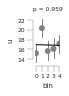

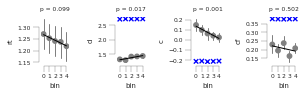

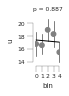

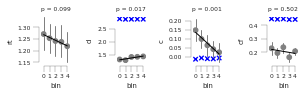

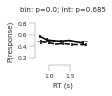

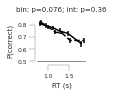

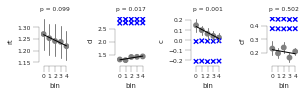

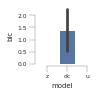

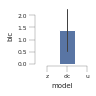

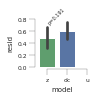

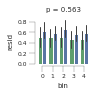

In [14]:
# for analyse_exp in [0,1,2,3,4,5]:
for analyse_exp in [2]:
    exp_name, bin_measure, n_bins = exp_names[analyse_exp], bin_measures[analyse_exp], nrs_bins[analyse_exp]

    # load data:
    df = pd.read_csv(os.path.join(project_dir, 'data', 'ddm', '{}.csv'.format(exp_name)))

    # compute T_dur:
    T_dur = df['rt'].max()+1

    # set options:
    model_settings = [
        # pyddm:
        {'fit': 'pyddm', 'depends_on': {'a':['bin'], 'u':None,    'v':['bin'], 't':['bin'], 'z':['bin'], 'b':['bin']}, 'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #0
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':None,    'v':None,    't':None,    'z':['bin'], 'b':None   }, 'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #1
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':None,    'v':None,    't':None,    'z':None,    'b':['bin']}, 'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #2
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':['bin'], 'v':None,    't':None,    'z':None,    'b':None   }, 'start_bias': True,  'drift_bias': False, 'urgency':True,  'T_dur':T_dur}, #3
        {'fit': 'pyddm', 'depends_on': {'a':['bin'], 'u':None,    'v':['bin'], 't':['bin'], 'z':['bin'], 'b':['bin']}, 'start_bias': True,  'drift_bias': True,  'urgency':True,  'T_dur':T_dur}, #4
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':None,    'v':None,    't':None,    'z':['bin'], 'b':None   }, 'start_bias': True,  'drift_bias': False, 'urgency':True,  'T_dur':T_dur}, #5
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':None,    'v':None,    't':None,    'z':None,    'b':['bin']}, 'start_bias': False, 'drift_bias': True,  'urgency':True,  'T_dur':T_dur}, #6
        {'fit': 'pyddm', 'depends_on': {'a':None,    'u':['bin'], 'v':None,    't':None,    'z':None,    'b':None   }, 'start_bias': True,  'drift_bias': False, 'urgency':True,  'T_dur':T_dur}, #7
        # hddm:
        {'fit': 'hddm',  'depends_on':{'a':None, 'u':None, 'v':None, 't':None, 'z':None, 'b':None},                    'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #8
        {'fit': 'hddm',  'depends_on': {'a':['bin'], 'u':None,    'v':['bin'], 't':['bin'], 'z':['bin']},              'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #9
        {'fit': 'hddm',  'depends_on': {'a':['bin'], 'u':None,    'v':['bin'], 't':['bin'], 'b':['bin']},              'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #10
        {'fit': 'hddm',  'depends_on': {'a':['bin'], 'u':None,    'v':['bin'], 't':['bin'], 'z':['bin'], 'b':['bin']}, 'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}, #11
        ]
    if 'gonogo' in exp_name:
        model_settings[-4] = {'fit': 'hddm_q', 'depends_on':{'a':None, 'u':None, 'v':None, 't':None, 'z':None, 'b':None},                               'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}        #8
        model_settings[-3] = {'fit': 'hddm_q', 'depends_on':{'a':['bin'], 'u':None, 'v':['bin'], 't':['bin'], 'z':['bin'], 'b':None},                   'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}        #9
        model_settings[-2] = {'fit': 'hddm_q', 'depends_on':{'a':['bin'], 'u':None, 'v':['bin'], 't':['bin'], 'z': None,   'b':['bin']},                'start_bias': True,  'drift_bias': True,  'urgency':False, 'T_dur':T_dur}        #10
        model_settings[-1] = {'fit': 'hddm_q', 'depends_on':{'a':['bin'], 'u':None, 'v':['bin', 'level'], 't':['bin', 'level'], 'z':None, 'b':['bin', 'level']}, 'start_bias': True, 'drift_bias': True, 'urgency':False, 'T_dur':T_dur} #11 
    
    for version in versions:

        # cut dataframe:
        if 'gonogo' in exp_name:
            df_emp = df.loc[:,['subj_idx', 'response', 'rt', 'stimulus', 'correct', 'level', bin_measure]]
            if version == 11:
                df_emp = analyses_tools.prepare_df(df_emp)
                df_emp['bin'] = df_emp.groupby(['subj_idx', 'level', 'stimulus'])[bin_measure].apply(pd.qcut, q=n_bins, labels=False)
            else:
                df_emp['level'] = 1
                df_emp['bin'] = df_emp.groupby(['subj_idx', 'stimulus'])[bin_measure].apply(pd.qcut, q=n_bins, labels=False)
        elif exp_name == 'image_recognition':        
            df_emp = df.loc[:,['subj_idx', 'response', 'rt', 'stimulus', 'correct', 'emotional', bin_measure]]
            df_emp['bin'] = df_emp.groupby(['subj_idx', 'emotional'])[bin_measure].apply(pd.qcut, q=n_bins, labels=False)
        else:
            df_emp = df.loc[:,['subj_idx', 'response', 'rt', 'stimulus', 'correct', bin_measure]]
            df_emp['bin'] = df_emp.groupby(['subj_idx'])[bin_measure].apply(pd.qcut, q=n_bins, labels=False)

        # fit model:
        if analysis_step == 0:
            
            if model_settings[version]['fit'] == 'pyddm':
                from accumodels import pyddm_tools
                df_emp.loc[df_emp['stimulus']==0, 'stimulus'] = -1 # pyddm expects -1 and 1 as stimuli identifiers
                res = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(delayed(pyddm_tools.fit_model)
                                (data, model_settings[version], subj_idx) for subj_idx, data in df_emp.groupby(['subj_idx']))
                params = pd.concat(res).reset_index(drop=True)
            elif model_settings[version]['fit'] == 'hddm':
                from accumodels import hddm_tools
                params = hddm_tools.fit_ddm(df_emp, model_settings[version], model_dir=os.path.join(project_dir, 'fits'), 
                                                        model_name='{}_{}'.format(exp_name, version), 
                                                        samples=12500, burn=2500, thin=2, model_id=0)
                                                        # samples=100, burn=10, thin=2, model_id=0)
            if model_settings[version]['fit'] == 'hddm_q':
                from accumodels import hddm_tools
                res = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(delayed(hddm_tools.fit_ddm)
                                (data, model_settings[version], os.path.join(project_dir, 'fits'), 
                                '{}_{}'.format(exp_name, version), subj_idx) for subj_idx, data in df_emp.groupby(['subj_idx']))
                params = pd.concat(res).reset_index(drop=True)
                print(params['bic'].mean())
                # shell()

            params.to_csv(os.path.join(project_dir, 'fits', '{}_{}.csv'.format(exp_name, version)))

        elif analysis_step == 1:
            
            from accumodels import pyddm_tools, plot_tools

            # simulate data:
            params = pd.read_csv(os.path.join(project_dir, 'fits', '{}_{}.csv'.format(exp_name, version)))
            
            df_emp.loc[df_emp['stimulus']==0, 'stimulus'] = -1 # pyddm expects -1 and 1 as stimuli identifiers
            df_sim = pd.concat(Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(delayed(pyddm_tools.simulate_data)(data, params, model_settings[version], subj_idx, 100000)
                                for subj_idx, data in df_emp.groupby(['subj_idx']))).reset_index()
            df_sim.to_csv(os.path.join(project_dir, 'fits', '{}_{}_df_sim.csv'.format(exp_name, version)))
            
            # model fit:
            if not 'bin' in df_sim.columns:
                df_emp['bin'] = 1
                df_sim['bin'] = 1
            for b, d in df_emp.groupby(['bin']):
                fig = plot_tools.summary_plot_group(df_emp.loc[df_emp['bin']==b,:], df_sim.loc[df_sim['bin']==b,:])
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_model_fit_{}.pdf'.format(exp_name, version, b)))

    # analyses:
    if analysis_step == 2:
        
        bics = []
        resids = []
        sdt_emps = []
        sdt_sims = []
        df_sims = []
        for version in versions:
            
            # load:
            params = pd.read_csv(os.path.join(project_dir, 'fits', '{}_{}.csv'.format(exp_name, version)))
            params.loc[:, [p[0]=='a' for p in params.columns]] = params.loc[:, [p[0]=='a' for p in params.columns]] * 2 
            if 'recognition' in exp_name:
                params = params_melt(params, model_settings[version], flip_b=True)
            else:
                params = params_melt(params, model_settings[version])
            df_sim = pd.read_csv(os.path.join(project_dir, 'fits', '{}_{}_df_sim.csv'.format(exp_name, version)))
            df_sim.loc[df_sim['stimulus']==-1, 'stimulus'] = 0 # we now expects 0 and 1 as stimuli identifiers
            df_sims.append(df_sim)

            # empirical and simulated SDT:
            if 'gonogo' in exp_name:
                sdt_emp_ = analyses_tools.compute_behavior(df=df_emp, groupby=['subj_idx', 'level', 'bin'])
                sdt_sim_ = analyses_tools.compute_behavior(df=df_sim, groupby=['subj_idx', 'level', 'bin'])
                sdt_sim = sdt_sim_.melt(id_vars=['subj_idx', 'level', 'bin'])
                sdt_emp = sdt_emp_.melt(id_vars=['subj_idx', 'level', 'bin'])

                # collapsed across volume, including composite bias:
                sdt_emp_bin = sdt_emp_.groupby(['subj_idx', 'bin']).mean().reset_index().drop('level', axis=1)
                sdt_sim_bin = sdt_sim_.groupby(['subj_idx', 'bin']).mean().reset_index().drop('level', axis=1)
                sdt_emp_bin['c2'] = np.array(df_emp.groupby(['subj_idx', 'bin']).apply(analyses_tools.composite_bias))
                sdt_sim_bin['c2'] = np.array(df_sim.groupby(['subj_idx', 'bin']).apply(analyses_tools.composite_bias))
                sdt_emp_bin = sdt_emp_bin.melt(id_vars=['subj_idx', 'bin'])
                sdt_sim_bin = sdt_sim_bin.melt(id_vars=['subj_idx', 'bin'])

                # collapsed across pupil bin:
                sdt_emp_level = sdt_emp.groupby(['subj_idx', 'variable', 'level']).mean().reset_index().drop('bin', axis=1)
                sdt_sim_level = sdt_sim.groupby(['subj_idx', 'variable', 'level']).mean().reset_index().drop('bin', axis=1)
                
            else:
                sdt_emp = analyses_tools.compute_behavior(df=df_emp, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
                sdt_sim = analyses_tools.compute_behavior(df=df_sim, groupby=['subj_idx', 'bin']).melt(id_vars=['subj_idx', 'bin'])
            sdt_emps.append(sdt_emp)
            sdt_sims.append(sdt_sim)

 #           if not 'gonogo' in exp_name:
 #               if exp_name == 'image_recognition':
 #                   y = np.array(sdt_emp.loc[(sdt_emp['variable']=='cf')&(sdt_emp['bin']==max(sdt_emp['bin'])), 'value']) - np.array(sdt_emp.loc[(sdt_emp['variable']=='cf')&(sdt_emp['bin']==min(sdt_emp['bin'])), 'value'])
 #               else:
#                    y = np.array(sdt_emp.loc[(sdt_emp['variable']=='c')&(sdt_emp['bin']==max(sdt_emp['bin'])), 'value']) - np.array(sdt_emp.loc[(sdt_emp['variable']=='c')&(sdt_emp['bin']==min(sdt_emp['bin'])), 'value'])
 #               X = np.vstack(( np.array(params.loc[(params['variable']=='z')&(params['bin']==max(params['bin'])), 'value']) - np.array(params.loc[(params['variable']=='z')&(params['bin']==min(params['bin'])), 'value']),
 #                               np.array(params.loc[(params['variable']=='b')&(params['bin']==max(params['bin'])), 'value']) - np.array(params.loc[(params['variable']=='b')&(params['bin']==min(params['bin'])), 'value'])))
#                X = sm.add_constant(X.T)
 #               est = sm.OLS(y, X).fit()
 #               print()
 #               print()
 #               print(est.summary())
  #              r1,p1 = sp.stats.pearsonr(y, X[:,1])
 #               r2,p2 = sp.stats.pearsonr(y, X[:,2])

 #               fig = plt.figure(figsize=(1.75,1.6))
 #               ax = fig.add_subplot(111)
  #              sns.regplot(x=y, y=X[:,1], color='green', scatter_kws={'s':4}, ax=ax)
  #              plt.xlabel('∆ criterion (s.d.)')
  #              plt.ylabel('∆ starting point')
  #              ax = ax.twinx()
  #              sns.regplot(x=y, y=X[:,2], scatter_kws={'s':4}, ax=ax)
  #              plt.ylabel('∆ drift bias')
  #              plt.title('r={}, p={}\nr={}, p={}\n'.format(round(r1,3), round(p1,3), round(r2,3), round(p2,3)))
                # sns.despine(offset=2, trim=True)
    #            plt.tight_layout()
  #              fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_correlations.pdf'.format(exp_name, version)))
            
            # DDM bars:
            if 'gonogo' in exp_name:
                params_bin = params.groupby(['subj_idx', 'variable', 'bin']).mean().reset_index().drop('level', axis=1)
                params_level = params.groupby(['subj_idx', 'variable', 'level']).mean().reset_index().drop('bin', axis=1)
                fig = analyses_tools.mixed_linear_modeling(params_bin, x='bin')
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_bars_bin.pdf'.format(exp_name, version)))
                fig = analyses_tools.mixed_linear_modeling(params_level, x='level')
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_bars_level.pdf'.format(exp_name, version)))
                fig = analyses_tools.mixed_linear_modeling(params.loc[~pd.isnull(params['bin'])&~pd.isnull(params['level']),:], x='bin')
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_bars1.pdf'.format(exp_name, version)))
                
            else:
                fig = analyses_tools.mixed_linear_modeling(params.loc[~pd.isnull(params['bin']),:], x='bin')
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_bars.pdf'.format(exp_name, version)))

            # SDT bars:
            fig = analyses_tools.mixed_linear_modeling(sdt_emp, x='bin', df_sims=[sdt_sim], colors=['blue'])
            fig.savefig(os.path.join(project_dir, 'figs', '{}_{}_sdt_bars.pdf'.format(exp_name, version)))

            if 'gonogo' in exp_name:

                fig = analyses_tools.mixed_linear_modeling(sdt_emp_bin, x='bin', df_sims=[sdt_sim_bin], colors=['blue'])
                fig.savefig(os.path.join(project_dir, 'figs', '{}_{}_sdt_bars_bin.pdf'.format(exp_name, version)))

                fig = analyses_tools.mixed_linear_modeling(sdt_emp_level, x='level', df_sims=[sdt_sim_level], colors=['blue'])
                fig.savefig(os.path.join(project_dir, 'figs', '{}_{}_sdt_bars_level.pdf'.format(exp_name, version)))
                        
            # resid:
            resid = pd.DataFrame(sdt_emp.loc[sdt_emp['variable']=='c', ['subj_idx', 'bin', 'value']]).reset_index(drop=True)
            resid['value'] = (resid['value'] - np.array(sdt_sim.loc[sdt_emp['variable']=='c', 'value']))**2
            resid['model'] = version
            resids.append(resid)

            # bics:
            bic = pd.DataFrame(params.loc[params['variable']=='bic', ['subj_idx', 'value']]).reset_index(drop=True)
            bic['model'] = version
            bics.append(bic)

        if (version == 3) | (version == 7):
            
            #shell()

            df_emp_ = df_emp.copy()
            if exp_name == 'image_recognition':
                sdt_emp_ = analyses_tools.compute_behavior(df=df_emp_, groupby=['subj_idx'])
                subjects = sdt_emp_.loc[sdt_emp_['c']<0,'subj_idx']
                df_emp_.loc[df_emp_['subj_idx'].isin(subjects), 'response'] = (~df_emp_.loc[df_emp_['subj_idx'].isin(subjects), 'response'].astype(bool)).astype(int)
            fig = analyses_tools.conditional_response_plot(df=df_emp_, quantiles=[0,0.1,0.3,0.5,0.7,0.9,1], y='response', ylim=(0.1, 0.9), df_sims=None, color=None)
            fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_crf.pdf'.format(exp_name, version)))
            fig = analyses_tools.conditional_response_plot(df=df_emp_, quantiles=[0,0.1,0.3,0.5,0.7,0.9,1], y='correct', df_sims=None, color=None)
            fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_caf.pdf'.format(exp_name, version)))

            # SDT analysis:
            colors = sns.color_palette(n_colors=3)
            colors = [colors[2], colors[0], colors[1]]
            # if exp_name == 'bias_manipulation':
            #     for (c), d in df_emp.groupby(['cons']):
            #         sdt_sims_ = []
            #         for sdt_sim in sdt_sims:
            #             sdt_sims_.append(sdt_sim.loc[(sdt_sim['cons']==c),:])
            #         fig = analyses_tools.mixed_linear_modeling(sdt_emp.loc[(sdt_emp['cons']==c),:], x='bin', df_sims=sdt_sims_, colors=colors)
            #         fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_sdt_bars_{}.pdf'.format(exp_name, version, c)))
            # else:
            fig = analyses_tools.mixed_linear_modeling(sdt_emp, x='bin', df_sims=sdt_sims, colors=colors)
            fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_sdt_bars.pdf'.format(exp_name, version)))

            # BICs & residuals:
            bics = pd.concat(bics)
            resids = pd.concat(resids)
            # resids = resids.groupby(['subj_idx', 'model']).mean().reset_index()
            print()
            print(exp_name)
            print(bics.groupby('model').mean())        
            print(resids.groupby('model').mean())

            # subtract bics:
            subtract = np.array(bics.loc[bics['model']==bics['model'].min(), 'value'])
            for m in bics['model'].unique():
                bics.loc[bics['model']==m, 'value'] = np.array(bics.loc[bics['model']==m, 'value']) - subtract
            
            # # subtract resids:
            # subtract = np.array(resids.loc[resids['model']==resids['model'].min(), 'value'])
            # for m in resids['model'].unique():
            #     resids.loc[resids['model']==m, 'value'] = np.array(resids.loc[resids['model']==m, 'value']) - subtract
            
            # # resids only in lowest and highest pupil bin:
            # resids = resids.loc[(resids['bin']==min(resids['bin']))|(resids['bin']==max(resids['bin'])),:]

            for data, title in zip([bics, resids], ['bic', 'resid']):

                fig = plt.figure(figsize=(1.5,1.5))
                sns.barplot(x='model', y='value', units='subj_idx', palette=colors, ci=66, data=data)
                # sns.stripplot(x='model', y='value', color='grey', size=2, data=data)
                if not title == 'bic':
                    for i, m in enumerate(versions):

                        if not i == 1:
                            t,p = sp.stats.ttest_rel(resids.loc[resids['model']==m,'value'], resids.loc[resids['model']==versions[1],'value'])
                            plt.text(i, plt.gca().get_ylim()[1]-((plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])/10), 'p={}'.format(round(p,3)), size=5, rotation=45)

                plt.xticks([0,1,2], ['z', 'dc', 'u'])
                plt.ylabel(title)
                sns.despine(offset=2, trim=True)
                plt.tight_layout()
                fig.savefig(os.path.join(project_dir, 'figs', 'ddm', '{}_{}_{}.pdf'.format(exp_name, version, title)))

                fig = plt.figure(figsize=(1.5,1.5))
                if title == 'bic':
                    sns.barplot(x='model', y='value', units='subj_idx', ci=66, errwidth=1, palette=colors, data=data)
                    plt.xticks([0,1,2], ['z', 'dc', 'u'])
                if title == 'resid':
                    sns.barplot(x='bin', y='value', hue='model', units='subj_idx', ci=66, errwidth=1, palette=colors, data=data)
                    aovrm = AnovaRM(data, 'value', 'subj_idx', within=['model','bin'], aggregate_func='mean')
                    res = aovrm.fit()
                    print(res)
                    plt.title('p = {}'.format(round(res.anova_table.iloc[0]['Pr > F'],3)))
                    # plt.xticks([0,1,2], ['z', 'dc', 'u'])
                plt.ylabel(title)
                try:
                    plt.gca().get_legend().remove()
                except:
                    pass
                sns.despine(offset=2, trim=True)

                plt.tight_layout()

[3]